# Metro Interstate Traffic Volume

**Data Set Information:**

Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.


**Attribute Information:**

**- holiday:** Categorical US National holidays plus regional holiday, Minnesota State Fair;<br>
**- temp:** Numeric Average temp in kelvin;<br>
**- rain_1h:** Numeric Amount in mm of rain that occurred in the hour;<br>
**- snow_1h:** Numeric Amount in mm of snow that occurred in the hour;<br>
**- clouds_all:** Numeric Percentage of cloud cover;<br>
**- weather_main:** Categorical Short textual description of the current weather;<br>
**- weather_description:** Categorical Longer textual description of the current weather;<br>
**- date_time:** DateTime Hour of the data collected in local CST time;<br>
**- traffic_volume:** Numeric Hourly I-94 ATR 301 reported westbound traffic volume.

### Import Libraries

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

import sys
sys.path.insert(1, '../RegressionAlgorithms/')
import linearRegression

### Get the Data

In [77]:
data = pd.read_csv('MetroInterstateTrafficVolume.csv')

In [78]:
data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


### Basic Data Information

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 2.6+ MB


In [80]:
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [81]:
data.describe(include = 'object')

,holiday,weather_main,weather_description,date_time
count,48204,48204,48204,48204
unique,12,11,38,40575
top,None,Clouds,sky is clear,2013-05-19 10:00:00
freq,48143,15164,11665,6


### Check missing values

In [82]:
print(data.isnull().sum(axis=0))

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64


### Exploratory Data Analysis

**Traffic Volume**

*Histogram of Traffic Volume distribution*

Text(0.5, 0, 'traffic_volume')

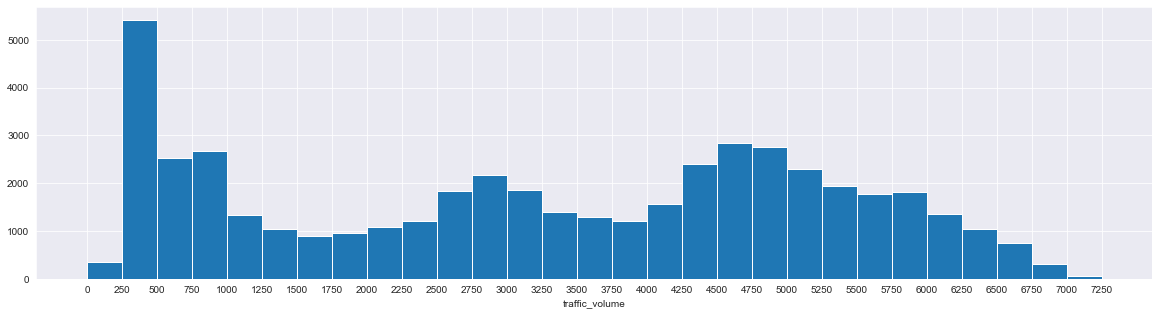

In [83]:
fig = plt.figure(figsize = (20,5))
sns.set_style('darkgrid')
bins = np.arange(0, 7500, 250).tolist()
data['traffic_volume'].hist(bins=bins)
plt.xticks(bins)
plt.xlabel('traffic_volume')

**Traffic Volume vs Holiday**

*Check holidays included in the dataset*

In [84]:
data['holiday'].unique()

array(['None', 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

*Box plot of Traffic Volume vs Holiday distribution*

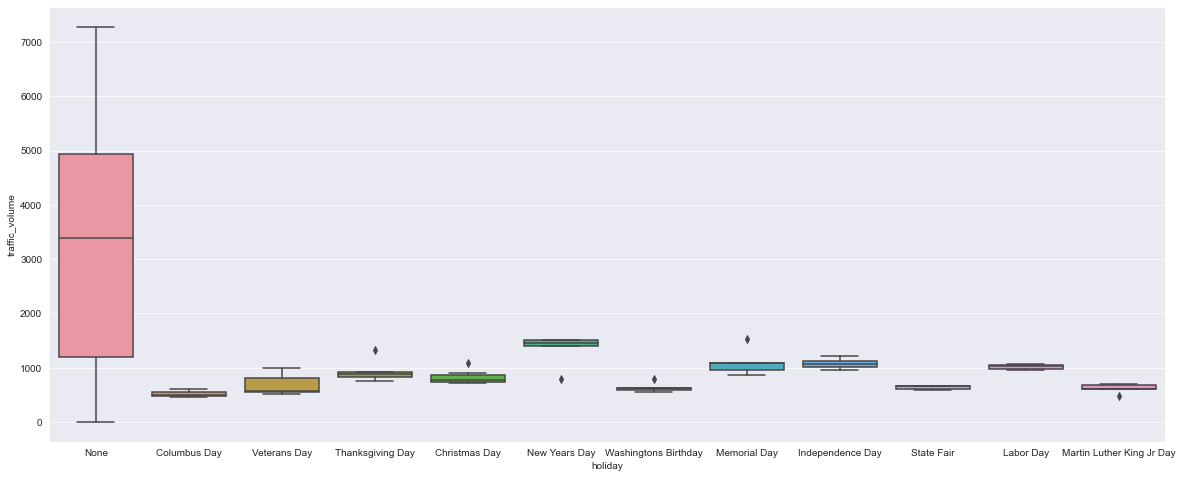

In [85]:
plt.figure(figsize=(20, 8))
sns.boxplot(x=data['holiday'], y=data['traffic_volume'])
plt.show()

*Distribution only with the holidays*

In [86]:
data_holidays = data.loc[(data['holiday'] != 'None')]
data_holidays.index = np.arange(1, len(data_holidays) + 1)
data_holidays

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
1,Columbus Day,273.080,0.00,0.0,20,Clouds,few clouds,2012-10-08 00:00:00,455
2,Veterans Day,288.120,0.00,0.0,87,Clear,sky is clear,2012-11-12 00:00:00,1000
3,Thanksgiving Day,278.540,0.00,0.0,20,Mist,mist,2012-11-22 00:00:00,919
4,Christmas Day,264.400,0.00,0.0,90,Clouds,overcast clouds,2012-12-25 00:00:00,803
5,New Years Day,263.490,0.00,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439
...,...,...,...,...,...,...,...,...,...
57,Memorial Day,299.487,0.00,0.0,24,Clouds,few clouds,2018-05-28 00:00:00,1088
58,Independence Day,297.550,0.00,0.0,1,Mist,mist,2018-07-04 00:00:00,1021
59,State Fair,289.020,0.00,0.0,1,Clear,sky is clear,2018-08-23 00:00:00,596
60,Labor Day,292.430,0.25,0.0,1,Rain,light rain,2018-09-03 00:00:00,962


*Box plot of Traffic Volume vs Holiday distribution (only holidays included)*

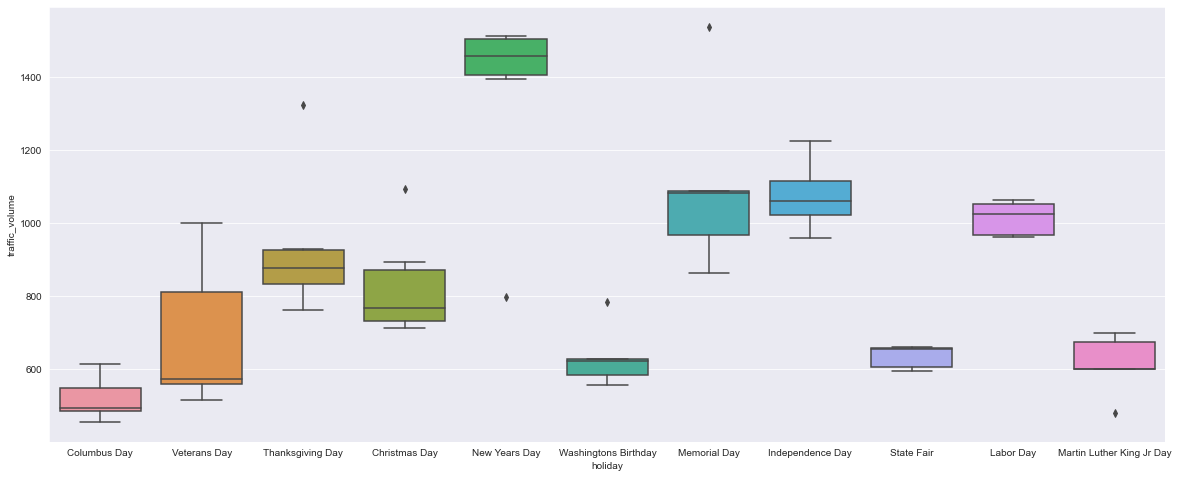

In [87]:
plt.figure(figsize=(20, 8))
sns.boxplot(x=data_holidays['holiday'], y=data_holidays['traffic_volume'])
plt.show()

**Traffic Volume vs Temperature**

*Plot of Traffic Volume vs Temperature distribution*

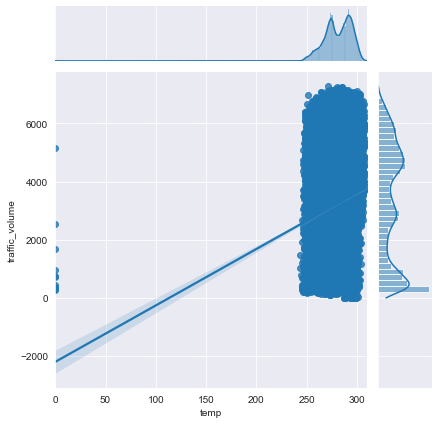

In [88]:
fig = sns.jointplot(x=data['temp'], y=data['traffic_volume'], kind='reg')

*Removing outliers*

In [89]:
outliers = data[(data['temp'] <= 50)]
data = data.drop(outliers.index)
data.index = np.arange(1, len(data) + 1)
outliers

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
11898,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 03:00:00,361
11899,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 04:00:00,734
11900,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 05:00:00,2557
11901,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-01-31 06:00:00,5150
11946,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 03:00:00,291
11947,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 04:00:00,284
11948,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 05:00:00,434
11949,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 06:00:00,739
11950,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 07:00:00,962
11951,None,0.0,0.0,0.0,0,Clear,sky is clear,2014-02-02 08:00:00,1670


*Plot of Traffic Volume vs Temperature distribution (without outliers)*

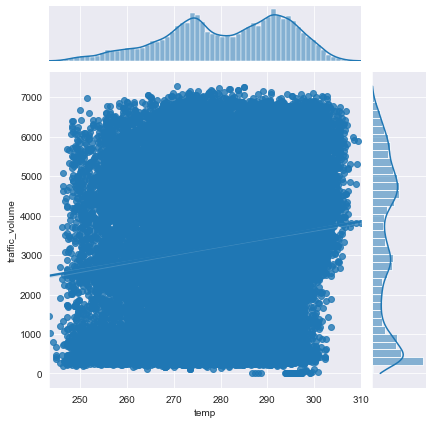

In [90]:
fig = sns.jointplot(x=data['temp'], y=data['traffic_volume'], kind='reg')

**Traffic Volume vs Rain**

*Plot of Traffic Volume vs Rain distribution*

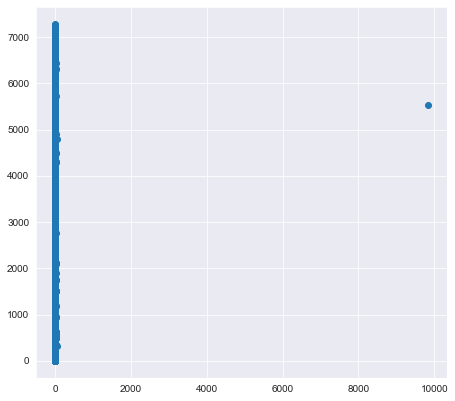

In [91]:
fig = plt.figure(figsize = (25,15))
ax1 = fig.add_subplot(2,3,1)
ax1.scatter(data['rain_1h'], data['traffic_volume'])

*Removing outliers*

In [92]:
outliers = data[(data['rain_1h'] >= 1000)]
data = data.drop(outliers.index)
data.index = np.arange(1, len(data) + 1)
outliers

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
24863,None,302.11,9831.3,0.0,75,Rain,very heavy rain,2016-07-11 17:00:00,5535


*Plot of Traffic Volume vs Rain distribution (without outliers)*

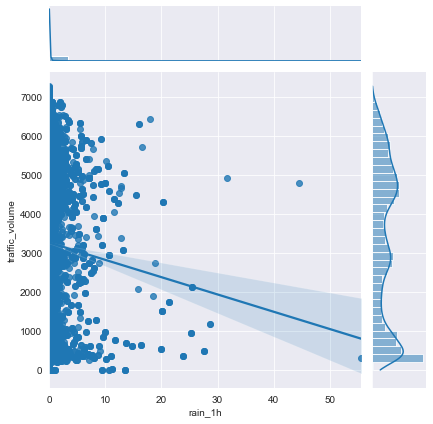

In [93]:
fig = sns.jointplot(x=data['rain_1h'], y=data['traffic_volume'], kind='reg')

*Distribution only with rainy days*

In [94]:
data_rainy = data.loc[(data['rain_1h'] > 0)]
#data_rainy = data.loc[(data['weather_main'] == "Rain")]
data_rainy.index = np.arange(1, len(data_rainy) + 1)
data_rainy

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
1,None,288.86,0.25,0.0,92,Rain,light rain,2013-06-05 10:00:00,4423
2,None,289.11,0.25,0.0,92,Rain,moderate rain,2013-06-05 11:00:00,4756
3,None,289.48,0.25,0.0,92,Rain,light rain,2013-06-05 12:00:00,4959
4,None,289.54,0.25,0.0,92,Rain,light rain,2013-06-05 13:00:00,5093
5,None,289.30,0.25,0.0,92,Rain,light rain,2013-06-05 15:00:00,6055
...,...,...,...,...,...,...,...,...,...
3462,None,279.43,0.25,0.0,75,Rain,light rain,2018-09-26 08:00:00,6032
3463,None,286.49,0.25,0.0,75,Rain,light rain,2018-09-27 05:00:00,3002
3464,None,286.88,0.25,0.0,90,Rain,light rain,2018-09-27 11:00:00,4670
3465,None,276.18,0.25,0.0,1,Rain,light rain,2018-09-29 00:00:00,1733


*Plot of Traffic Volume vs Rain distribution (only rainy days included)*

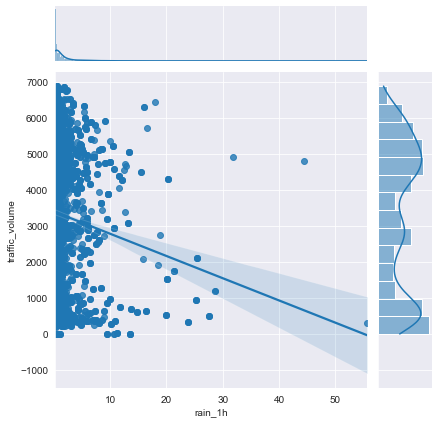

In [95]:
fig = sns.jointplot(x=data_rainy['rain_1h'], y=data_rainy['traffic_volume'], kind='reg')

**Traffic Volume vs Snow**

*Plot of Traffic Volume vs Snow distribution*

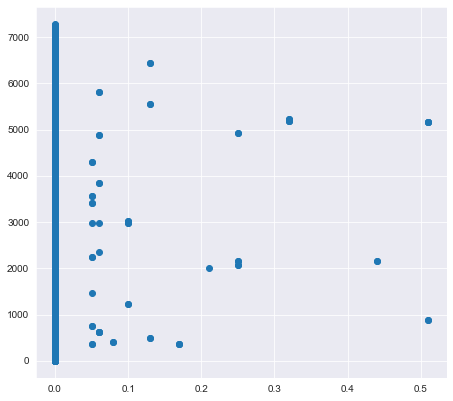

In [96]:
fig = plt.figure(figsize = (25,15))
ax1 = fig.add_subplot(2,3,1)
ax1.scatter(data['snow_1h'], data['traffic_volume'])

*Distribution only with snowy days*

In [97]:
data_snowy = data.loc[(data['snow_1h'] > 0)]
#data_snowy = data.loc[(data['weather_main'] == "Snow")]
data_snowy.index = np.arange(1, len(data_snowy) + 1)
data_snowy

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
1,None,274.33,0.98,0.51,90,Rain,moderate rain,2015-12-23 12:00:00,5167
2,None,274.33,0.98,0.51,90,Snow,snow,2015-12-23 12:00:00,5167
3,None,274.33,0.98,0.51,90,Mist,mist,2015-12-23 12:00:00,5167
4,None,274.33,0.98,0.51,90,Fog,fog,2015-12-23 12:00:00,5167
5,None,273.74,0.00,0.32,90,Snow,light snow,2015-12-23 14:00:00,5182
...,...,...,...,...,...,...,...,...,...
59,None,273.22,0.00,0.08,90,Mist,mist,2016-01-08 03:00:00,401
60,None,273.80,0.00,0.25,90,Snow,light snow,2016-01-08 13:00:00,4933
61,None,273.80,0.00,0.25,90,Mist,mist,2016-01-08 13:00:00,4933
62,None,273.67,0.00,0.13,90,Snow,light snow,2016-01-08 15:00:00,5548


*Plot of Traffic Volume vs Snow distribution (only snowy days included)*

c:\users\enric\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


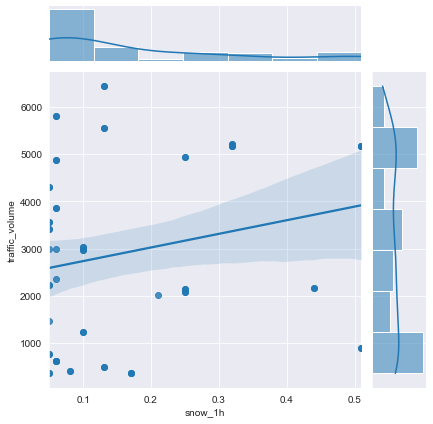

In [98]:
fig = sns.jointplot(data_snowy['snow_1h'], data_snowy['traffic_volume'], kind='reg')

**Traffic Volume vs Cloud cover**

*Plot of Traffic Volume vs Cloud cover distribution*

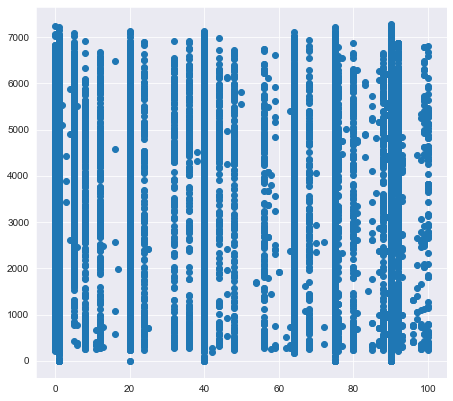

In [99]:
fig = plt.figure(figsize = (25,15))

ax1 = fig.add_subplot(2,3,1)
ax1.scatter(data['clouds_all'], data['traffic_volume'])

In [100]:
#data['clouds_all'].unique()
#x = data['clouds_all'].value_counts()
#y = list(x[:10].index)

#plt.figure(figsize=(20, 8))
#sns.boxplot(data['clouds_all'], data['traffic_volume'])
#plt.show()

**Traffic Volume vs Current weather**

*Box plot of Traffic Volume vs Current weather distribution*

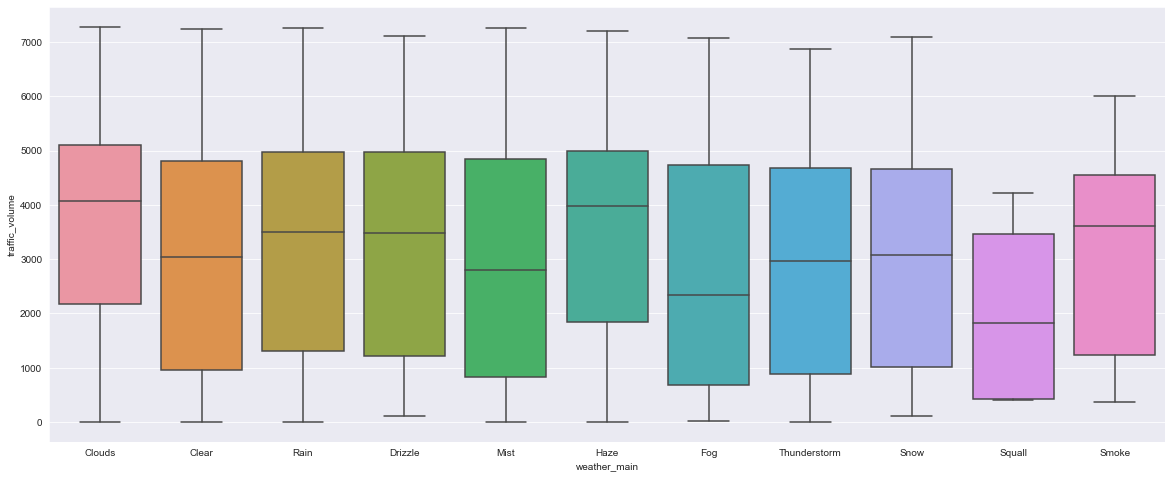

In [101]:
plt.figure(figsize=(20, 8))
sns.boxplot(x=data['weather_main'], y=data['traffic_volume'])
plt.show()

**Traffic Volume vs Date time**

*Separation of the date elements*

In [102]:
data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
1,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
2,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
3,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
4,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
5,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48189,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48190,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48191,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48192,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [103]:
data[['year','month','day','hour','minutes','seconds']] = data['date_time'].str.extract(r'(\d+)-(\d+)-(\d+)\s*(\d+):(\d+):(\d+)', expand=True)
data = data.drop(['date_time'], axis=1)

*Dataset with new labels*

In [104]:
data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,year,month,day,hour,minutes,seconds
1,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,2012,10,02,09,00,00
2,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,2012,10,02,10,00,00
3,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,2012,10,02,11,00,00
4,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,2012,10,02,12,00,00
5,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,2012,10,02,13,00,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48189,None,283.45,0.0,0.0,75,Clouds,broken clouds,3543,2018,09,30,19,00,00
48190,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2781,2018,09,30,20,00,00
48191,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159,2018,09,30,21,00,00
48192,None,282.09,0.0,0.0,90,Clouds,overcast clouds,1450,2018,09,30,22,00,00


*Box plot of Traffic Volume vs Year*

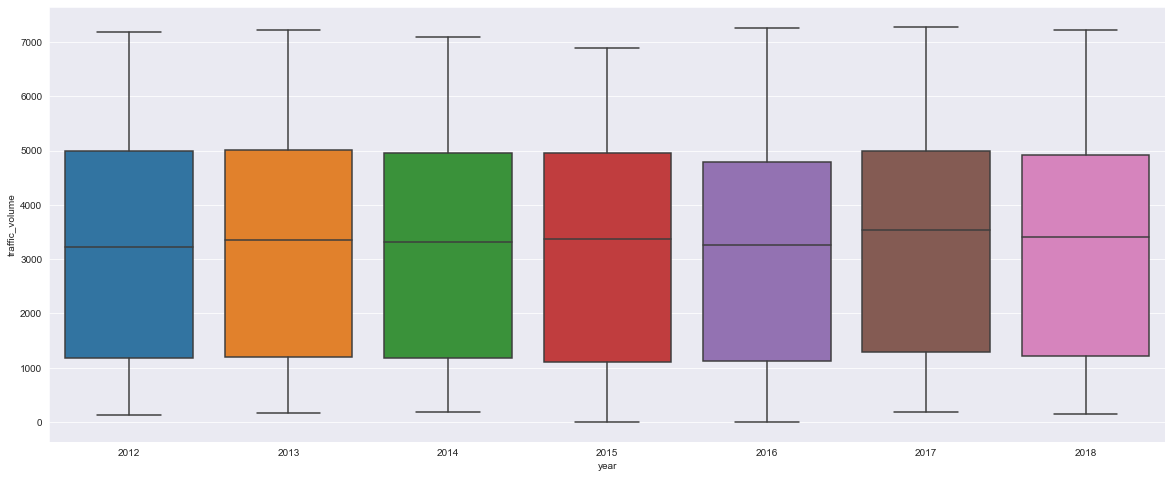

In [105]:
plt.figure(figsize=(20, 8))
sns.boxplot(x=data['year'], y=data['traffic_volume'])
plt.show()

*Box plot of Traffic Volume vs Month*

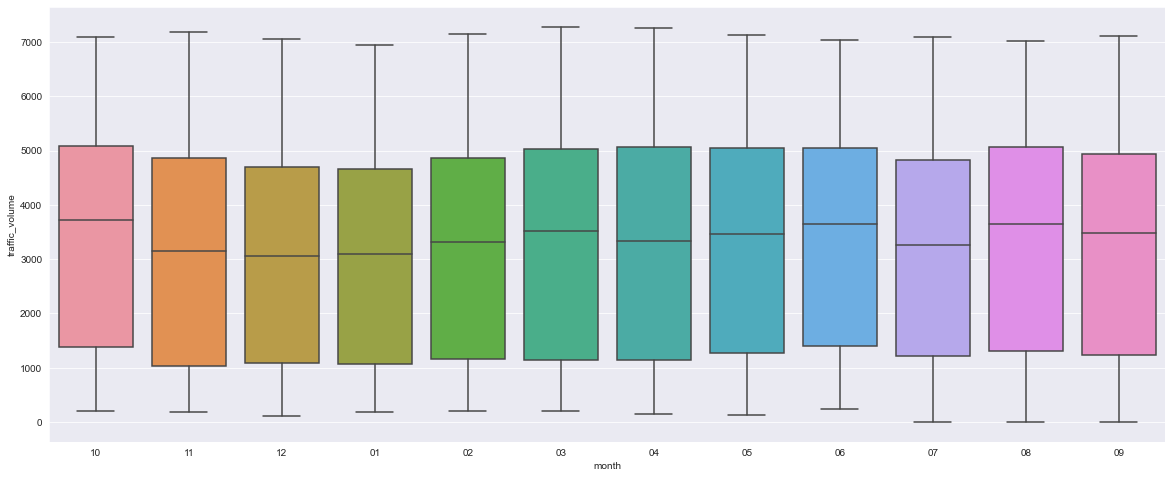

In [106]:
plt.figure(figsize=(20, 8))
sns.boxplot(x=data['month'], y=data['traffic_volume'])
plt.show()

*Box plot of Traffic Volume vs Hour*

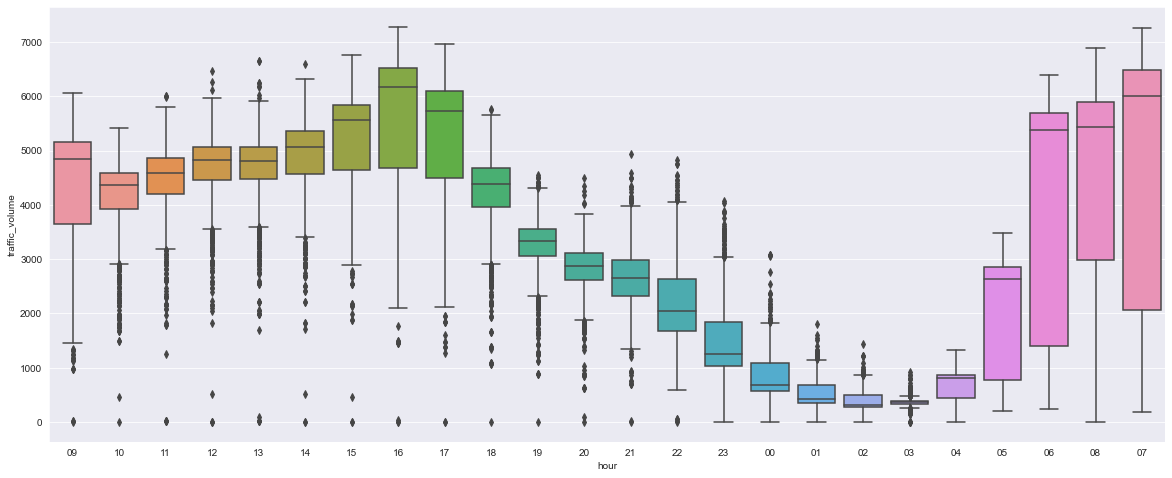

In [107]:
plt.figure(figsize=(20, 8))
sns.boxplot(x=data['hour'], y=data['traffic_volume'])
plt.show()

In [108]:
data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,year,month,day,hour,minutes,seconds
1,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,2012,10,02,09,00,00
2,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,2012,10,02,10,00,00
3,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,2012,10,02,11,00,00
4,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,2012,10,02,12,00,00
5,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,2012,10,02,13,00,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48189,None,283.45,0.0,0.0,75,Clouds,broken clouds,3543,2018,09,30,19,00,00
48190,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2781,2018,09,30,20,00,00
48191,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159,2018,09,30,21,00,00
48192,None,282.09,0.0,0.0,90,Clouds,overcast clouds,1450,2018,09,30,22,00,00


## Preprocessing

*Drop minutes and second columns*

In [109]:
data.drop(['minutes', 'seconds'], axis=1)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,year,month,day,hour
1,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,2012,10,02,09
2,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,2012,10,02,10
3,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,2012,10,02,11
4,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,2012,10,02,12
5,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,2012,10,02,13
...,...,...,...,...,...,...,...,...,...,...,...,...
48189,None,283.45,0.0,0.0,75,Clouds,broken clouds,3543,2018,09,30,19
48190,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2781,2018,09,30,20
48191,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2159,2018,09,30,21
48192,None,282.09,0.0,0.0,90,Clouds,overcast clouds,1450,2018,09,30,22


*Preprocess Non Ordinal Data*

In [110]:
one_hot = pd.get_dummies(data["weather_main"])
data = data.drop("weather_main",axis = 1)
data = data.join(one_hot)

In [111]:
one_hot = pd.get_dummies(data["weather_description"])
data = data.drop("weather_description",axis = 1)
data = data.join(one_hot)

In [112]:
one_hot = pd.get_dummies(data["holiday"])
data = data.drop("holiday",axis = 1)
data = data.join(one_hot)

In [113]:
data

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,year,month,day,hour,minutes,...,Independence Day,Labor Day,Martin Luther King Jr Day,Memorial Day,New Years Day,None,State Fair,Thanksgiving Day,Veterans Day,Washingtons Birthday
1,288.28,0.0,0.0,40,5545,2012,10,02,09,00,...,0,0,0,0,0,1,0,0,0,0
2,289.36,0.0,0.0,75,4516,2012,10,02,10,00,...,0,0,0,0,0,1,0,0,0,0
3,289.58,0.0,0.0,90,4767,2012,10,02,11,00,...,0,0,0,0,0,1,0,0,0,0
4,290.13,0.0,0.0,90,5026,2012,10,02,12,00,...,0,0,0,0,0,1,0,0,0,0
5,291.14,0.0,0.0,75,4918,2012,10,02,13,00,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48189,283.45,0.0,0.0,75,3543,2018,09,30,19,00,...,0,0,0,0,0,1,0,0,0,0
48190,282.76,0.0,0.0,90,2781,2018,09,30,20,00,...,0,0,0,0,0,1,0,0,0,0
48191,282.73,0.0,0.0,90,2159,2018,09,30,21,00,...,0,0,0,0,0,1,0,0,0,0
48192,282.09,0.0,0.0,90,1450,2018,09,30,22,00,...,0,0,0,0,0,1,0,0,0,0


**Data Preparation**

In [114]:
X = data.drop('traffic_volume', axis=1)
y = data['traffic_volume']

In [115]:
scaler = StandardScaler()
scaler = scaler.fit(X)
X_scaled = scaler.transform(X)

#split the data in attributes and class as well as training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

## Regression Tasks

*Regression Algorithms from Sklearn*

### Linear Regression

In [119]:
model = linear_model.LinearRegression().fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# The coefficients
print('Coefficients: \n', model.coef_)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('-------------------------------------------')

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Coefficients: 
 [ 1.70899521e+01 -3.54280832e+01  8.15006444e+02  4.98603741e+00
  1.31997192e+00 -1.32511867e+01 -2.00812542e+00  9.12776676e+01
 -9.77706804e-12  2.68300937e-11  1.14639012e+02  2.41495538e+02
  5.60515563e+01 -5.92417584e+01  1.63437183e+02 -6.35267318e+01
  1.98341542e+02 -6.16148728e+01  5.63612998e+02 -7.85676713e+02
 -3.67517754e+02 -7.85676713e+02  1.54555154e+02  3.41040311e+01
 -3.28434598e+02  2.56849194e+02 -5.92417584e+01  4.92011144e+02
  1.63437183e+02  2.87139426e+02 -4.46776504e+02 -6.95166410e+02
 -1.14938029e+02  1.79088036e+02 -2.59094005e+02 -2.86985848e+02
  8.46611491e+02 -5.33553073e+02 -6.35267318e+01 -3.78390681e+02
 -2.67300550e+02  6.69118484e+02  7.77803808e+00  5.84793885e+02
 -1.49622783e+02  2.17842863e+02  2.12284757e+02  2.26924634e+03
 -3.99161414e+01  2.01908948e+02 -6.16148728e+01 -1.23844845e+03
  1.62110188e+00 -7.20850329e+02 -2.55343343e+02  2.17830528e+02
 -4.63882201e+02  4.10157347e+02 -5.76149312e+01  6.62954758e+01
 -4.33256

### KNN Regression

In [117]:
model = KNeighborsRegressor(n_neighbors=3).fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

print('-------------------------------------------')

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Coefficient of determination: 0.78
Mean Absolute Error: 610.6857333886659
Mean Squared Error: 885667.4307726595
Root Mean Squared Error: 941.0990547081957
